In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt

import keras
import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import ModelCheckpoint

import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix   

2023-05-22 05:06:00.107297: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-22 05:06:00.107343: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Import the data

In [2]:
import pandas as pd
from sklearn.utils import shuffle

# Read the CSV file into a pandas DataFrame
data = pd.read_csv("rumus + data skripsi angka polos jarak dan visibilitas 222.csv")

In [3]:
def get_data_with_ratio(ratio):
    # Shuffle the data
    shuffled_data = shuffle(data, random_state=42)

    # Get unique classes from the "Peruntukan" column
    classes = shuffled_data['Peruntukan'].unique()

    # Initialize empty dataframes for train and test data
    train_data = pd.DataFrame()
    test_data = pd.DataFrame()

    # Iterate over each class
    for cls in classes:
        cls_data = shuffled_data[shuffled_data['Peruntukan'] == cls]

        # Split the class data into train and test
        cls_train, cls_test = train_test_split(cls_data, test_size=ratio, random_state=42)

        # Append the train and test data to the respective dataframes
        train_data = train_data.append(cls_train)
        test_data = test_data.append(cls_test)
        
        training = train_data
        test = test_data

        training = training[["Peruntukan","Jarak pusat kota2","Visibilitas_2","Bangunan","Luas"]]
        test = test[["Peruntukan","Jarak pusat kota2","Visibilitas_2","Bangunan","Luas"]]


    
    return training, test


# Data visualisasi

# Change categorical to number 

In [4]:
def change_categorical_to_number(data):
    
    data = data
    
 
    ####
    ####

#     condition = [  data.Visibilitas == "Strategis",
#                  data.Visibilitas == "Sedang",
#                   data.Visibilitas == "Kurang",
#     ]

#     value = [3,2,1]

#     data.Visibilitas = np.select(condition,value)
    #####
    #####

    condition = [  data.Bangunan == "Bagus",
                 data.Bangunan == "Sedang",

    ]

    value = [2,1]

    data.Bangunan = np.select(condition,value,0)


    condition = [ 
                data.Peruntukan == "Pasar",
                 data.Peruntukan == "Kantor",
                 data.Peruntukan == "Ruko",
                 data.Peruntukan == "Taman",
                 data.Peruntukan == "Perumahan",
                 data.Peruntukan == "Sawah",

    ]

    value = [5,4,3,2,1,0]

    data.Peruntukan = np.select(condition,value,0)
    
    return data

# Dataframe to Dataset

In [5]:
def df_to_dataset(dataframe, shuffle=False, batch_size=4):
  dataframe = dataframe.copy()
  labels = dataframe.pop('Peruntukan')
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  return ds

# Feature Normalizer

In [6]:
def get_normalization_layer(name, dataset):
  # Create a Normalization layer for the feature.
  normalizer = layers.Normalization(axis=None)

  # Prepare a Dataset that only yields the feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the statistics of the data.
  normalizer.adapt(feature_ds)

  return normalizer

In [7]:
def encoded_features(train_ds):
    all_inputs = []
    encoded_features = []

    # Numerical features.
    for header in ["Jarak pusat kota2","Visibilitas_2","Bangunan","Luas"]:
      numeric_col = tf.keras.Input(shape=(1,), name=header)
      normalization_layer = get_normalization_layer(header, train_ds)
      encoded_numeric_col = normalization_layer(numeric_col)
      all_inputs.append(numeric_col)
      encoded_features.append(encoded_numeric_col)
    return encoded_features, all_inputs

In [8]:
checkpoint_callback = ModelCheckpoint("best_model.h5", monitor='val_accuracy', save_best_only=True, mode='max')

# Model build

In [9]:
def model(encoded_features,all_inputs):
    
    all_features = tf.keras.layers.concatenate(encoded_features)
    x = tf.keras.layers.Dense(64, activation="relu")(all_features)
    #x = tf.keras.layers.Dense(128, activation="relu")
    x = tf.keras.layers.Dropout(0.5)(x)
    output = tf.keras.layers.Dense(6)(x)

    model = tf.keras.Model(all_inputs, output)

    model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics="accuracy",
                 )
    
    return model

# History build

In [10]:
def history(model,callbacks,train_ds,val_ds):
    

    history = model.fit(train_ds, epochs=250, validation_data=val_ds, callbacks=callbacks)

    # Get the training and validation metrics from the history
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Plot accuracy
    plt.plot(train_accuracy, label='Training Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Plot loss
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    max_test_accuracy_index = history.history['val_accuracy'].index(max(history.history['val_accuracy']))

    # Get the corresponding training accuracy
    training_accuracy = history.history['accuracy'][max_test_accuracy_index]

    print('Best validation accuracy:', max(history.history['val_accuracy']))
    print('Training accuracy at the best test accuracy:', training_accuracy)
    
    return history


# Evaluation the Model

In [11]:
def run_model(ratio,callbacks):
    
    #split data
    training, test_2 = get_data_with_ratio(ratio)
    
    #change data to number
    training = change_categorical_to_number(training)
    test = change_categorical_to_number(test_2)
    
    #df to ds
    
    train_ds = df_to_dataset(training)
    val_ds = df_to_dataset(test)
    
    #encoded features
    
    encoded,inputs = encoded_features(train_ds)

    
    #set the model
    model_engine = model(encoded,inputs)
    
    #run and evaluate the model
    model_engine2 = history(model_engine,callbacks,train_ds,val_ds)
    
    #evaluate confusion matrix
    confussion_matrix(model_engine2,val_ds,test_2)

In [12]:
def confussion_matrix(best_model, val_ds,test_data):
    from sklearn.metrics import confusion_matrix   
    model =  best_model
    
    y_pred = model.model.predict(val_ds)

    # Ubah output prediksi menjadi label kelas
    label_kelas = [0, 1, 2, 3, 4, 5]
    y_pred_label = [label_kelas[np.argmax(prediksi)] for prediksi in y_pred]

    #test label
    test_labels = test_data.Peruntukan

    # Calculate the confusion matrix
    cm = confusion_matrix(test_labels, y_pred_label)
    
    max_test_accuracy_index = model.history['val_accuracy'].index(max(model.history['val_accuracy']))

    # Get the corresponding training accuracy
    training_accuracy = model.history['accuracy'][max_test_accuracy_index]

    print('Best validation accuracy:', max(model.history['val_accuracy']))
    print('Training accuracy at the best test accuracy:', training_accuracy)


    print('Confusion matrix:')
    print(cm)
    
    confusion_matrix = cm
    
    true_positives = np.diagonal(confusion_matrix)

    # Step 3: Calculate the accuracy percentage for each class
    class_data_totals = np.sum(confusion_matrix, axis=0)
    class_accuracies = true_positives / class_data_totals * 100

    # Step 4: Calculate the overall accuracy percentage
    total_instances = np.sum(confusion_matrix)
    overall_accuracy = np.sum(true_positives) / total_instances * 100

    
    for label, accuracy in zip(label_kelas, class_accuracies):
        print("Accuracy for", label, ":", accuracy)
    
    
    
    true_positives = np.diagonal(confusion_matrix)
    false_positives = np.sum(confusion_matrix, axis=0) - true_positives
    false_negatives = np.sum(confusion_matrix, axis=1) - true_positives

    # Step 3: Calculate precision, recall, and F1 score for each label
    accuracy = true_positives / np.sum(confusion_matrix, axis=1)
    precision = true_positives / (true_positives + false_positives)
    recall = true_positives / (true_positives + false_negatives)
    f1_score = 2 * (precision * recall) / (precision + recall)

    # Step 4: Calculate the total accuracy
    total_accuracy = np.sum(true_positives) / np.sum(confusion_matrix) * 100
    total_precision = np.mean(precision)
    total_recall = np.mean(recall)
    total_f1 = np.mean(f1_score)

    # Print the results
    print("Total Precision:", total_precision)
    print("Total Recall:", total_recall)
    print("Total F1 Score:", total_f1)

    # Print the results
    print("Accuracy for each label:", class_accuracies)
    print("Precision for each label:", precision)
    print("Recall for each label:", recall)
    print("F1 Score for each label:", f1_score)
    print("Total Accuracy:", total_accuracy)

# Model Evaluation

In [13]:
callback_1 = ModelCheckpoint("50.h5", monitor='val_accuracy', save_best_only=True, mode='max')
ratio_1 = 0.5

callback_2= ModelCheckpoint("40.h5", monitor='val_accuracy', save_best_only=True, mode='max')
ratio_2 = 0.4

callback_3= ModelCheckpoint("30.h5", monitor='val_accuracy', save_best_only=True, mode='max')
ratio_3 = 0.3

callback_4= ModelCheckpoint("20.h5", monitor='val_accuracy', save_best_only=True, mode='max')
ratio_4 = 0.2

callback_5= ModelCheckpoint("10.h5", monitor='val_accuracy', save_best_only=True, mode='max')
ratio_5 = 0.1

/tmp/ipykernel_508229/2250653428.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_data = train_data.append(cls_train)
/tmp/ipykernel_508229/2250653428.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_data = test_data.append(cls_test)
/tmp/ipykernel_508229/2250653428.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_data = train_data.append(cls_train)
/tmp/ipykernel_508229/2250653428.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_data = test_data.append(cls_test)
/tmp/ipykernel_508229/2250653428.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future v

Epoch 1/250
12/12 [==============================] - 1s 22ms/step - loss: 2.0237 - accuracy: 0.2708 - val_loss: 1.5858 - val_accuracy: 0.5370
Epoch 2/250
12/12 [==============================] - 0s 8ms/step - loss: 1.3443 - accuracy: 0.6667 - val_loss: 1.3835 - val_accuracy: 0.5741
Epoch 3/250
12/12 [==============================] - 0s 6ms/step - loss: 1.1489 - accuracy: 0.6250 - val_loss: 1.3692 - val_accuracy: 0.5556
Epoch 4/250
12/12 [==============================] - 0s 6ms/step - loss: 1.0058 - accuracy: 0.6458 - val_loss: 1.3320 - val_accuracy: 0.5556
Epoch 5/250
12/12 [==============================] - 0s 5ms/step - loss: 0.9345 - accuracy: 0.6458 - val_loss: 1.3393 - val_accuracy: 0.5556
Epoch 6/250
12/12 [==============================] - 0s 6ms/step - loss: 0.9305 - accuracy: 0.6250 - val_loss: 1.3416 - val_accuracy: 0.5556
Epoch 7/250
12/12 [==============================] - 0s 7ms/step - loss: 0.8152 - accuracy: 0.6667 - val_loss: 1.3151 - val_accuracy: 0.6111
Epoch 8/250


Epoch 59/250
12/12 [==============================] - 0s 5ms/step - loss: 0.4901 - accuracy: 0.7708 - val_loss: 3.5867 - val_accuracy: 0.7037
Epoch 60/250
12/12 [==============================] - 0s 5ms/step - loss: 0.4571 - accuracy: 0.7917 - val_loss: 3.5754 - val_accuracy: 0.7222
Epoch 61/250
12/12 [==============================] - 0s 5ms/step - loss: 0.4769 - accuracy: 0.7500 - val_loss: 3.6120 - val_accuracy: 0.7037
Epoch 62/250
12/12 [==============================] - 0s 5ms/step - loss: 0.5143 - accuracy: 0.7292 - val_loss: 3.6981 - val_accuracy: 0.7222
Epoch 63/250
12/12 [==============================] - 0s 5ms/step - loss: 0.5110 - accuracy: 0.7292 - val_loss: 3.7308 - val_accuracy: 0.7407
Epoch 64/250
12/12 [==============================] - 0s 6ms/step - loss: 0.4509 - accuracy: 0.7292 - val_loss: 3.6749 - val_accuracy: 0.7222
Epoch 65/250
12/12 [==============================] - 0s 6ms/step - loss: 0.4712 - accuracy: 0.7708 - val_loss: 3.7097 - val_accuracy: 0.7407
Epoch 

12/12 [==============================] - 0s 5ms/step - loss: 0.3210 - accuracy: 0.8333 - val_loss: 7.4261 - val_accuracy: 0.7037
Epoch 117/250
12/12 [==============================] - 0s 5ms/step - loss: 0.3399 - accuracy: 0.8333 - val_loss: 7.5844 - val_accuracy: 0.7037
Epoch 118/250
12/12 [==============================] - 0s 5ms/step - loss: 0.4122 - accuracy: 0.8125 - val_loss: 7.5932 - val_accuracy: 0.7037
Epoch 119/250
12/12 [==============================] - 0s 6ms/step - loss: 0.3675 - accuracy: 0.8333 - val_loss: 7.4598 - val_accuracy: 0.7222
Epoch 120/250
12/12 [==============================] - 0s 6ms/step - loss: 0.4559 - accuracy: 0.8333 - val_loss: 7.3559 - val_accuracy: 0.7222
Epoch 121/250
12/12 [==============================] - 0s 5ms/step - loss: 0.3207 - accuracy: 0.8333 - val_loss: 7.5357 - val_accuracy: 0.7222
Epoch 122/250
12/12 [==============================] - 0s 4ms/step - loss: 0.3689 - accuracy: 0.8333 - val_loss: 7.7658 - val_accuracy: 0.7222
Epoch 123/250

12/12 [==============================] - 0s 5ms/step - loss: 0.4864 - accuracy: 0.7292 - val_loss: 8.1691 - val_accuracy: 0.7037
Epoch 174/250
12/12 [==============================] - 0s 6ms/step - loss: 0.3533 - accuracy: 0.7500 - val_loss: 8.0669 - val_accuracy: 0.7407
Epoch 175/250
12/12 [==============================] - 0s 6ms/step - loss: 0.4137 - accuracy: 0.7917 - val_loss: 8.0471 - val_accuracy: 0.7037
Epoch 176/250
12/12 [==============================] - 0s 6ms/step - loss: 0.3374 - accuracy: 0.8542 - val_loss: 8.0224 - val_accuracy: 0.6852
Epoch 177/250
12/12 [==============================] - 0s 5ms/step - loss: 0.3253 - accuracy: 0.8750 - val_loss: 7.9610 - val_accuracy: 0.7037
Epoch 178/250
12/12 [==============================] - 0s 5ms/step - loss: 0.3429 - accuracy: 0.8750 - val_loss: 8.0339 - val_accuracy: 0.7037
Epoch 179/250
12/12 [==============================] - 0s 6ms/step - loss: 0.3004 - accuracy: 0.8542 - val_loss: 8.0866 - val_accuracy: 0.7222
Epoch 180/250

12/12 [==============================] - 0s 9ms/step - loss: 0.4895 - accuracy: 0.8333 - val_loss: 11.5096 - val_accuracy: 0.7037
Epoch 231/250
12/12 [==============================] - 0s 6ms/step - loss: 0.3548 - accuracy: 0.9167 - val_loss: 11.9061 - val_accuracy: 0.7037
Epoch 232/250
12/12 [==============================] - 0s 6ms/step - loss: 0.2780 - accuracy: 0.8958 - val_loss: 11.7143 - val_accuracy: 0.7407
Epoch 233/250
12/12 [==============================] - 0s 5ms/step - loss: 0.2848 - accuracy: 0.8750 - val_loss: 11.8209 - val_accuracy: 0.7222
Epoch 234/250
12/12 [==============================] - 0s 6ms/step - loss: 0.2807 - accuracy: 0.9167 - val_loss: 11.9774 - val_accuracy: 0.7222
Epoch 235/250
12/12 [==============================] - 0s 5ms/step - loss: 0.2792 - accuracy: 0.8542 - val_loss: 11.9343 - val_accuracy: 0.7407
Epoch 236/250
12/12 [==============================] - 0s 6ms/step - loss: 0.2322 - accuracy: 0.8958 - val_loss: 11.8825 - val_accuracy: 0.7222
Epoch 

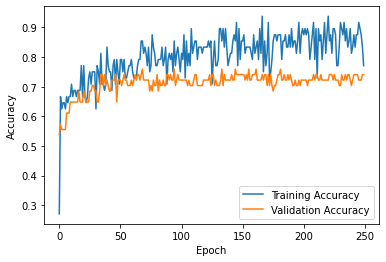

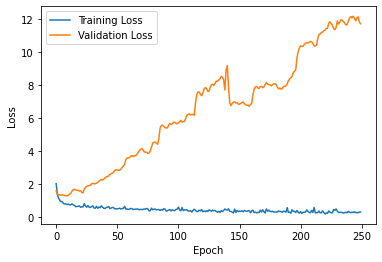

Best validation accuracy: 0.7592592835426331
Training accuracy at the best test accuracy: 0.8541666865348816
Best validation accuracy: 0.7592592835426331
Training accuracy at the best test accuracy: 0.8541666865348816
Confusion matrix:
[[12  0  0  0  0  0]
 [ 0  2  0  2  0  0]
 [ 0  0  3  0  0  0]
 [ 0  0  0 16  3  0]
 [ 0  0  0  3  3  2]
 [ 0  0  0  2  2  4]]
Accuracy for 0 : 100.0
Accuracy for 1 : 100.0
Accuracy for 2 : 100.0
Accuracy for 3 : 69.56521739130434
Accuracy for 4 : 37.5
Accuracy for 5 : 66.66666666666666
Total Precision: 0.7895531400966184
Total Recall: 0.7028508771929824
Total F1 Score: 0.7291666666666666
Accuracy for each label: [100.         100.         100.          69.56521739  37.5
  66.66666667]
Precision for each label: [1.         1.         1.         0.69565217 0.375      0.66666667]
Recall for each label: [1.         0.5        1.         0.84210526 0.375      0.5       ]
F1 Score for each label: [1.         0.66666667 1.         0.76190476 0.375      0.57142

In [14]:
run_model(ratio_1, callback_1)

In [ ]:
run_model(ratio_2, callback_2)

/tmp/ipykernel_508229/2250653428.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_data = train_data.append(cls_train)
/tmp/ipykernel_508229/2250653428.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_data = test_data.append(cls_test)
/tmp/ipykernel_508229/2250653428.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_data = train_data.append(cls_train)
/tmp/ipykernel_508229/2250653428.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_data = test_data.append(cls_test)
/tmp/ipykernel_508229/2250653428.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future v

Epoch 1/250
15/15 [==============================] - 1s 16ms/step - loss: 1.9520 - accuracy: 0.2333 - val_loss: 1.6271 - val_accuracy: 0.4286
Epoch 2/250
15/15 [==============================] - 0s 6ms/step - loss: 1.3623 - accuracy: 0.5833 - val_loss: 1.5479 - val_accuracy: 0.5476
Epoch 3/250
15/15 [==============================] - 0s 7ms/step - loss: 1.0824 - accuracy: 0.5500 - val_loss: 1.5852 - val_accuracy: 0.5714
Epoch 4/250
15/15 [==============================] - 0s 5ms/step - loss: 1.0122 - accuracy: 0.6333 - val_loss: 1.6333 - val_accuracy: 0.5714
Epoch 5/250
15/15 [==============================] - 0s 4ms/step - loss: 0.9629 - accuracy: 0.6333 - val_loss: 1.6039 - val_accuracy: 0.5714
Epoch 6/250
15/15 [==============================] - 0s 5ms/step - loss: 0.9769 - accuracy: 0.5667 - val_loss: 1.5941 - val_accuracy: 0.5714
Epoch 7/250
15/15 [==============================] - 0s 6ms/step - loss: 0.8230 - accuracy: 0.7167 - val_loss: 1.5791 - val_accuracy: 0.6190
Epoch 8/250


Epoch 59/250
15/15 [==============================] - 0s 4ms/step - loss: 0.4705 - accuracy: 0.7833 - val_loss: 5.1518 - val_accuracy: 0.7143
Epoch 60/250
15/15 [==============================] - 0s 4ms/step - loss: 0.5525 - accuracy: 0.7500 - val_loss: 5.2102 - val_accuracy: 0.7381
Epoch 61/250
15/15 [==============================] - 0s 4ms/step - loss: 0.4895 - accuracy: 0.7500 - val_loss: 5.1281 - val_accuracy: 0.7143
Epoch 62/250
15/15 [==============================] - 0s 4ms/step - loss: 0.4559 - accuracy: 0.7667 - val_loss: 5.2132 - val_accuracy: 0.6905
Epoch 63/250
15/15 [==============================] - 0s 4ms/step - loss: 0.5031 - accuracy: 0.7833 - val_loss: 5.3504 - val_accuracy: 0.7619
Epoch 64/250
15/15 [==============================] - 0s 4ms/step - loss: 0.4650 - accuracy: 0.8000 - val_loss: 5.4137 - val_accuracy: 0.7619
Epoch 65/250
15/15 [==============================] - 0s 4ms/step - loss: 0.4664 - accuracy: 0.8000 - val_loss: 5.5407 - val_accuracy: 0.6905
Epoch 

15/15 [==============================] - 0s 4ms/step - loss: 0.3365 - accuracy: 0.8667 - val_loss: 9.0457 - val_accuracy: 0.7143
Epoch 117/250
15/15 [==============================] - 0s 4ms/step - loss: 0.3520 - accuracy: 0.8333 - val_loss: 9.1021 - val_accuracy: 0.7143
Epoch 118/250
15/15 [==============================] - 0s 4ms/step - loss: 0.3875 - accuracy: 0.8167 - val_loss: 9.1314 - val_accuracy: 0.7381
Epoch 119/250
15/15 [==============================] - 0s 4ms/step - loss: 0.3513 - accuracy: 0.8667 - val_loss: 9.1688 - val_accuracy: 0.7381
Epoch 120/250
15/15 [==============================] - 0s 5ms/step - loss: 0.3206 - accuracy: 0.8333 - val_loss: 9.1993 - val_accuracy: 0.7143
Epoch 121/250
15/15 [==============================] - 0s 5ms/step - loss: 0.3732 - accuracy: 0.8333 - val_loss: 9.1398 - val_accuracy: 0.7381
Epoch 122/250
15/15 [==============================] - 0s 5ms/step - loss: 0.6779 - accuracy: 0.8333 - val_loss: 9.5505 - val_accuracy: 0.6905
Epoch 123/250

15/15 [==============================] - 0s 5ms/step - loss: 0.3582 - accuracy: 0.8500 - val_loss: 14.4399 - val_accuracy: 0.6905
Epoch 174/250
15/15 [==============================] - 0s 4ms/step - loss: 0.3133 - accuracy: 0.8667 - val_loss: 14.4894 - val_accuracy: 0.7143
Epoch 175/250
15/15 [==============================] - 0s 4ms/step - loss: 0.2940 - accuracy: 0.9000 - val_loss: 14.6189 - val_accuracy: 0.6905
Epoch 176/250
15/15 [==============================] - 0s 4ms/step - loss: 0.3303 - accuracy: 0.8833 - val_loss: 14.7365 - val_accuracy: 0.7143
Epoch 177/250
15/15 [==============================] - 0s 4ms/step - loss: 0.3257 - accuracy: 0.8500 - val_loss: 14.8365 - val_accuracy: 0.7143
Epoch 178/250
15/15 [==============================] - 0s 5ms/step - loss: 0.2878 - accuracy: 0.8667 - val_loss: 14.9680 - val_accuracy: 0.7143
Epoch 179/250
15/15 [==============================] - 0s 5ms/step - loss: 0.2997 - accuracy: 0.8833 - val_loss: 14.9727 - val_accuracy: 0.7143
Epoch 

Epoch 230/250
15/15 [==============================] - 0s 4ms/step - loss: 0.2247 - accuracy: 0.8667 - val_loss: 15.7521 - val_accuracy: 0.7143
Epoch 231/250
15/15 [==============================] - 0s 4ms/step - loss: 0.3419 - accuracy: 0.8833 - val_loss: 15.7588 - val_accuracy: 0.6905
Epoch 232/250
15/15 [==============================] - 0s 4ms/step - loss: 0.3137 - accuracy: 0.8833 - val_loss: 15.8605 - val_accuracy: 0.7143
Epoch 233/250
15/15 [==============================] - 0s 4ms/step - loss: 0.2895 - accuracy: 0.8667 - val_loss: 15.9794 - val_accuracy: 0.6667
Epoch 234/250
15/15 [==============================] - 0s 4ms/step - loss: 0.2418 - accuracy: 0.9000 - val_loss: 15.9879 - val_accuracy: 0.7143
Epoch 235/250
 1/15 [=>............................] - ETA: 0s - loss: 0.1125 - accuracy: 1.0000

In [ ]:
run_model(ratio_3, callback_3)

In [ ]:
run_model(ratio_4, callback_4)

In [ ]:
run_model(ratio_5, callback_5)

# 

# N